In [1]:
!git clone https://github.com/marcotcr/lime.git

Cloning into 'lime'...
remote: Enumerating objects: 2389, done.
remote: Total 2389 (delta 0), reused 0 (delta 0), pack-reused 2389
Receiving objects: 100% (2389/2389), 21.41 MiB | 10.59 MiB/s, done.
Resolving deltas: 100% (1600/1600), done.


In [2]:
!pip install lime

  Using cached lime-0.2.0.1-py3-none-any.whl


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb 

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
X_vec = np.stack([gray2rgb(iimg) for iimg in mnist.data.values.astype(np.uint8).reshape((-1, 28, 28))],0).astype(np.uint8)
y_vec = mnist.target.astype(np.uint8)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Text(0.5, 1.0, 'Digit: 5')

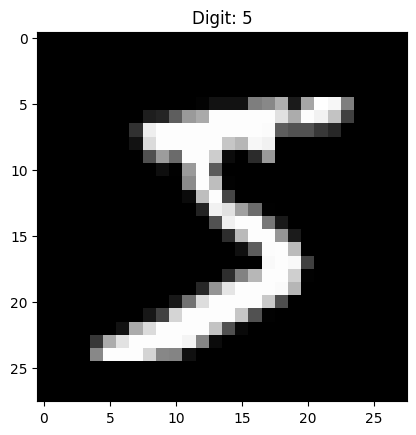

In [5]:
%matplotlib inline
fig, ax1 = plt.subplots(1,1)
ax1.imshow(X_vec[0], interpolation = 'none')
ax1.set_title('Digit: {}'.format(y_vec[0]))

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer

class PipeStep(object):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)


makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_rf_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    ('RF', RandomForestClassifier())
                              ])

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec,
                                                    train_size=0.55)

In [8]:
simple_rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x7ca842e2dcc0>),
                ('Flatten Image', <__main__.PipeStep object at 0x7ca842e2d810>),
                ('RF', RandomForestClassifier())])

In [9]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..'))
    import lime

In [10]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [11]:
%%time
explanation = explainer.explain_instance(X_test[0],
                                         classifier_fn = simple_rf_pipeline.predict_proba,
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 7.31 s, sys: 189 ms, total: 7.5 s
Wall time: 7.6 s


Text(0.5, 1.0, 'Positive/Negative Regions for 9')

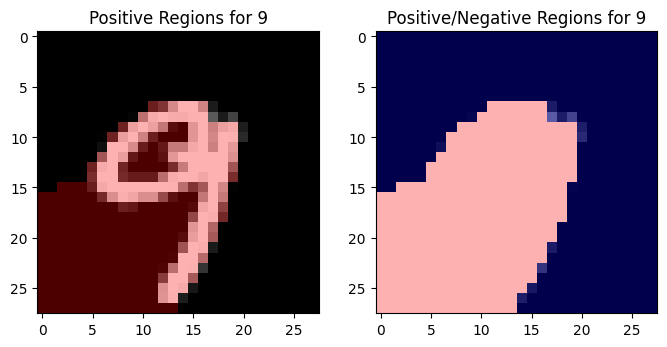

In [13]:

temp, mask = explanation.get_image_and_mask(y_test.iloc[0], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test.iloc[0]))
temp, mask = explanation.get_image_and_mask(y_test.iloc[0], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test.iloc[0]))

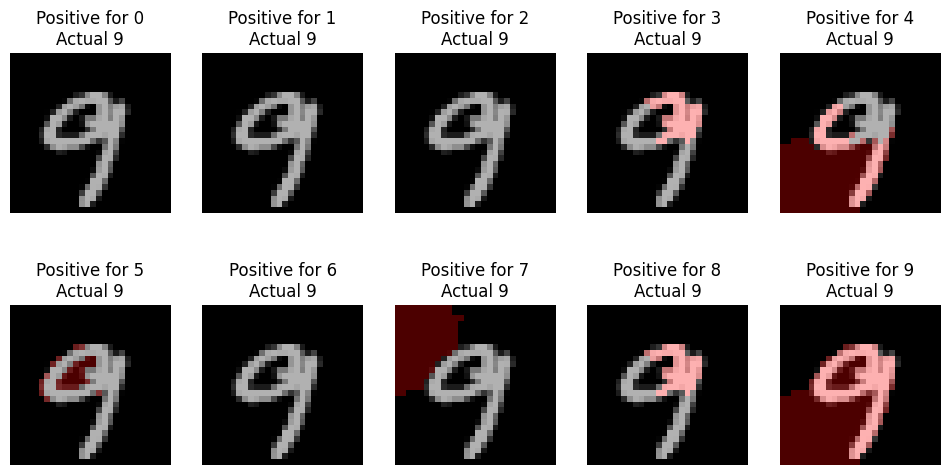

In [15]:
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,X_test[0], bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test.iloc[0]))
    c_ax.axis('off')

In [17]:
pipe_pred_test = simple_rf_pipeline.predict(X_test)
wrong_idx = np.random.choice(np.where(pipe_pred_test!=y_test)[0])
print('Using #{} where the label was {} and the pipeline predicted {}'.format(wrong_idx, y_test.iloc[wrong_idx], pipe_pred_test[wrong_idx]))

Using #488 where the label was 7 and the pipeline predicted 9


In [18]:
%%time
explanation = explainer.explain_instance(X_test[wrong_idx],
                                         classifier_fn = simple_rf_pipeline.predict_proba,
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 8.13 s, sys: 138 ms, total: 8.27 s
Wall time: 8.52 s


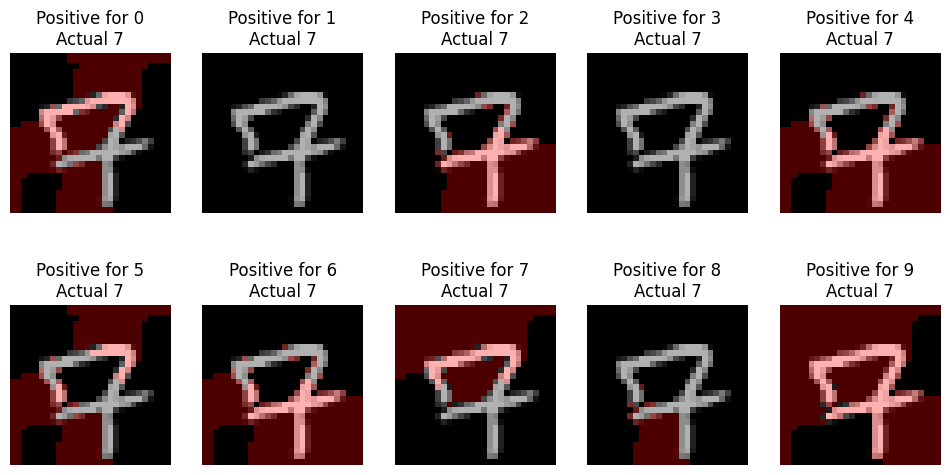

In [20]:
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test.iloc[wrong_idx]))
    c_ax.axis('off')